In [12]:
!pip install -q kaggle

In [13]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d zuozhaorui/celeba

In [15]:
!unzip -qq celeba

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [9]:
import glob, os, cv2, time, PIL, imageio
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from IPython import display

In [10]:
epochs = 60
width = height = 64

### Load and prepare the dataset


In [17]:
train_images = []
i = 0
for image_name in os.listdir('img_align_celeba')[0:20000]:

    # if image_name != 'img_align_celeba':
    image = cv2.imread(f'img_align_celeba/{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))
    train_images.append(image)

In [18]:
train_images = np.array(train_images)

In [19]:
train_images = train_images.astype('float32')

In [20]:
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [21]:
BUFFER_SIZE = 2000
BATCH_SIZE = 256

In [22]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [23]:
def make_generator_model():
    generator_model = tf.keras.Sequential()
    generator_model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    generator_model.add(layers.BatchNormalization())
    generator_model.add(layers.LeakyReLU())

    generator_model.add(layers.Reshape((8, 8, 256)))
    assert generator_model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    generator_model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert generator_model.output_shape == (None, 8, 8, 128)
    generator_model.add(layers.BatchNormalization())
    generator_model.add(layers.LeakyReLU())

    generator_model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert generator_model.output_shape == (None, 16, 16, 64)
    generator_model.add(layers.BatchNormalization())
    generator_model.add(layers.LeakyReLU())

    generator_model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert generator_model.output_shape == (None, 32, 32, 64)
    generator_model.add(layers.BatchNormalization())
    generator_model.add(layers.LeakyReLU())

    generator_model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert generator_model.output_shape == (None, 64, 64, 3)

    return generator_model

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :], cmap='gray')

### The Discriminator

In [25]:
def make_discriminator_model():
    discriminator_model = tf.keras.Sequential()
    discriminator_model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    discriminator_model.add(layers.LeakyReLU())
    discriminator_model.add(layers.Dropout(0.3))

    discriminator_model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    discriminator_model.add(layers.LeakyReLU())
    discriminator_model.add(layers.Dropout(0.3))

    discriminator_model.add(layers.Flatten())
    discriminator_model.add(layers.Dense(1))

    return discriminator_model

In [26]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00252174]], shape=(1, 1), dtype=float32)


In [27]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [29]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [32]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [33]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [34]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [37]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(12, 12))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((np.array(predictions[i, :, :, :] * 127.5 ) + 127.5 ).astype('uint8'), cmap = 'gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

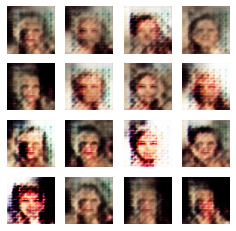

In [39]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [40]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [41]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

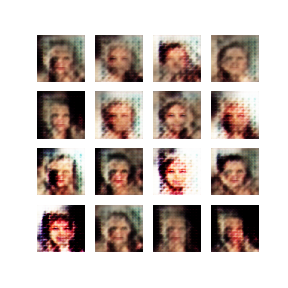

In [42]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [43]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


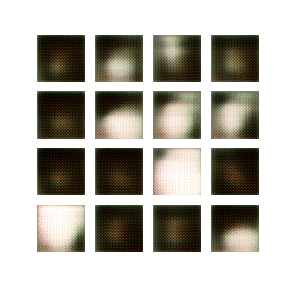

In [44]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)